# 图片风格迁移

给定一张图片的内容和另一张图片的风格，生成一张新的图片：
<img style="float: center;" src="images/12.png" width="70%">

风格迁移论文：
- 《A Neural Algorithm of Artistic Style》
- https://arxiv.org/pdf/1508.06576.pdf

思想：两张图片：左边叫content，中间叫style，要做的事情就是生成一张新的图片，既包含左边图片的内容，也有中间图片的风格
- 首先拷贝一张和左边图像一样的图片，这样就保证了内容
- 图片由像素组成，像素是三维张量
- 这张图片经过神经网络后，提取内容特征，分别与内容图片和风格图片产生一种差异上的损失，从而更新这个张量（注意这里不是更新网络的参数），网络在这里作为一个特征提取器，更新的是这张图片的像素值
- 经过多轮后，就会发现，这个张量既有左边图像的内容，也有中间图像的风格

## 导入包

使用torchvision工具包，封装了对图像的一系列预处理操作和一些模型，包含三个模块：
- torchvision.transforms：图像预处理方法，标准化、中心化、旋转、翻转等操作
- torchvision.datasets：数据集dataset实现，MNIST，CIFAR-10，ImageNet等
- torchvision.models：模型预训练，AlexNet，VGG，ResNet，GoogLeNet

In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import utils as vutils
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 导入数据集

In [2]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    # 读入图片,进行预处理
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        # print(size)
        image = image.resize(size.astype(int), Image.ANTIALIAS)   # 改变图片大小
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)  # Image.LANCZOS插值
        
    if transform:
        #print(image)   # PIL的JpegImageFile格式(size=(W，H))
        image = transform(image).unsqueeze(0)   
        #print(image.shape)   #   [C, H, W] 
    return image.to(device)


transform = transforms.Compose([
    # 将numpy数组或PIL.Image图片转换成(C,H,W)的Tensor格式且/255归一化到[0,1.0]之间
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])      
]) # 来自ImageNet的mean和variance

content = load_image("data/ArtisticStyle/Con1.png", transform, max_size=400)
style = load_image("data/ArtisticStyle/Style1.png", transform, shape=[content.size(2), content.size(3)])

print(content.shape, style.shape)

torch.Size([1, 3, 251, 400]) torch.Size([1, 3, 400, 251])


上述代码最后看两张图片的shape，发现后两维是转置关系
- 发现明明上面style那行代码设置shape是content的第2维和第3维，为何真实情况变了？
- 问题在transforms.ToTensor()和PIL.Image上，load_image函数里用Image.open()读取图片，这个格式是PIL.Image格式的size=(W, H)，即宽度在前，高度在后。
- 经过ToTensor()之后，是(C, H, W)三维张量，高度在前，宽度在后
- 因此才会有两张照片转置关系

归一化之后图片的样子

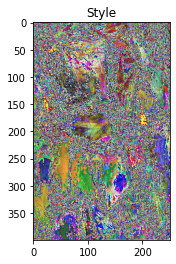

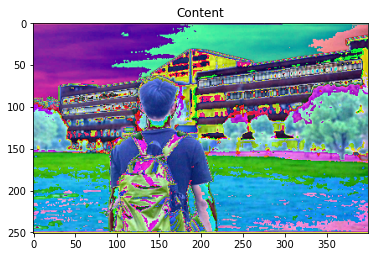

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Style')
imshow(content[0], title='Content')

## 迁移VGG神经网络

作为特征提取器，提取图片内容

In [4]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        # 选择vgg19的某些层
        self.select = ['0', '5', '10', '19', '28']
        # 拿出vgg19的前面部分，后面的分类器舍弃掉
        # vgg19整个网络分为两个部分
        # 一个features，特征提取部分
        # 一个分类部分
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


# target是最终目标，初始化是content的复制，知识requires_grad设置为true，可训练
target = content.clone().requires_grad_(True)
# 优化器的目标是target，而不是model.parameters()
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()    # 注意， 这个VGG已经是不训练状态了

可以看target经过vgg之后，提取到了什么东西：

In [5]:
target_features = vgg(target)

In [6]:
for i in range(len(target_features)):
    print(target_features[i].shape)

torch.Size([1, 64, 251, 400])
torch.Size([1, 128, 125, 200])
torch.Size([1, 256, 62, 100])
torch.Size([1, 512, 31, 50])
torch.Size([1, 512, 15, 25])


发现经过5层之后，会提取到五个张量

## 训练

分别让content，target，style经过vgg网络，得到上面5个张量（即它们各自的特征），针对每一层的特征，计算损失：
- Content Loss：$L_{content}(\vec{p},\vec{x},l)=\frac{1}{2}\sum_{i,j}\left(F^l_{ij}-P^l_{ij}\right)^2$，F是特征向量
- Style Loss：$G^l_{ij}=\sum_k F^l_{ik}F^l_{jk}$，$E_l=\frac{1}{4N^2_lM^2_l}\sum_{i,j}\left(G^l_{ij}-A^l_{ij}\right)^2$

In [7]:
total_step = 3000
style_weight = 3000.

for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    # 对于每一层特征，计算损失
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # 内容损失
        content_loss += torch.mean((f1 - f2) ** 2)
        _, c, h, w = f1.size()  # [c, h, w]
        f1 = f1.view(c, h * w)  # [c, h*w]
        f3 = f3.view(c, h * w)  # [c, h*w]
        
        # 风格损失
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())    # [c, c]
        f3 = torch.mm(f3, f3.t())    # [c, c]
        style_loss += torch.mean((f1 - f3) ** 2) / (c * h * w)
        
    # 总的损失
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  

Step [0/3000], Content Loss: 0.0000, Style Loss: 1308.2753
Step [10/3000], Content Loss: 4.9314, Style Loss: 1120.9270
Step [20/3000], Content Loss: 12.4310, Style Loss: 909.6437
Step [30/3000], Content Loss: 17.4957, Style Loss: 741.0284
Step [40/3000], Content Loss: 21.1204, Style Loss: 614.5389
Step [50/3000], Content Loss: 23.9869, Style Loss: 518.0127
Step [60/3000], Content Loss: 26.3176, Style Loss: 443.5426
Step [70/3000], Content Loss: 28.2481, Style Loss: 385.4186
Step [80/3000], Content Loss: 29.8311, Style Loss: 339.5278
Step [90/3000], Content Loss: 31.1405, Style Loss: 302.6544
Step [100/3000], Content Loss: 32.2427, Style Loss: 272.5272
Step [110/3000], Content Loss: 33.1728, Style Loss: 247.5164
Step [120/3000], Content Loss: 33.9710, Style Loss: 226.3813
Step [130/3000], Content Loss: 34.6788, Style Loss: 208.2868
Step [140/3000], Content Loss: 35.3045, Style Loss: 192.6064
Step [150/3000], Content Loss: 35.8610, Style Loss: 178.8785
Step [160/3000], Content Loss: 36.3

Step [1360/3000], Content Loss: 48.3101, Style Loss: 11.6136
Step [1370/3000], Content Loss: 48.3416, Style Loss: 11.5248
Step [1380/3000], Content Loss: 48.3726, Style Loss: 11.4374
Step [1390/3000], Content Loss: 48.4035, Style Loss: 11.3513
Step [1400/3000], Content Loss: 48.4339, Style Loss: 11.2663
Step [1410/3000], Content Loss: 48.4655, Style Loss: 11.1827
Step [1420/3000], Content Loss: 48.4970, Style Loss: 11.1006
Step [1430/3000], Content Loss: 48.5280, Style Loss: 11.0198
Step [1440/3000], Content Loss: 48.5587, Style Loss: 10.9402
Step [1450/3000], Content Loss: 48.5893, Style Loss: 10.8619
Step [1460/3000], Content Loss: 48.6202, Style Loss: 10.7850
Step [1470/3000], Content Loss: 48.6505, Style Loss: 10.7091
Step [1480/3000], Content Loss: 48.6806, Style Loss: 10.6347
Step [1490/3000], Content Loss: 48.7098, Style Loss: 10.5611
Step [1500/3000], Content Loss: 48.7392, Style Loss: 10.4887
Step [1510/3000], Content Loss: 48.7679, Style Loss: 10.4172
Step [1520/3000], Conten

Step [2730/3000], Content Loss: 51.2537, Style Loss: 5.5781
Step [2740/3000], Content Loss: 51.2683, Style Loss: 5.5548
Step [2750/3000], Content Loss: 51.2840, Style Loss: 5.5316
Step [2760/3000], Content Loss: 51.2992, Style Loss: 5.5085
Step [2770/3000], Content Loss: 51.3156, Style Loss: 5.4856
Step [2780/3000], Content Loss: 51.3304, Style Loss: 5.4629
Step [2790/3000], Content Loss: 51.3470, Style Loss: 5.4402
Step [2800/3000], Content Loss: 51.3618, Style Loss: 5.4176
Step [2810/3000], Content Loss: 51.3767, Style Loss: 5.3953
Step [2820/3000], Content Loss: 51.3924, Style Loss: 5.3729
Step [2830/3000], Content Loss: 51.4072, Style Loss: 5.3507
Step [2840/3000], Content Loss: 51.4220, Style Loss: 5.3287
Step [2850/3000], Content Loss: 51.4361, Style Loss: 5.3069
Step [2860/3000], Content Loss: 51.4504, Style Loss: 5.2851
Step [2870/3000], Content Loss: 51.4649, Style Loss: 5.2634
Step [2880/3000], Content Loss: 51.4798, Style Loss: 5.2418
Step [2890/3000], Content Loss: 51.4943,

如果训练正常，内容损失越来越大，风格损失越来越小

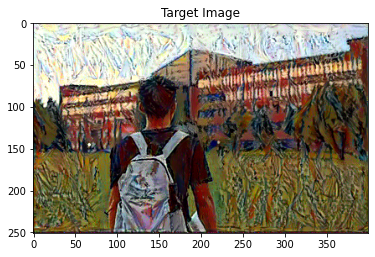

In [8]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))  # 反归一化
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)    # 控制到0-1
plt.figure()
imshow(img, title='Target Image')

## 保存图片

In [9]:
vutils.save_image(img, 'target.png', normalize=True)

# 生成对抗网络—手写数字识别

原理：通过生成器的和判别器互相较量而让彼此互相变强。

判别器是二分类网络，负责判断给定图片真假，训练判别器的时候，先用一批真实的图片进行训练，然后生成器生成的假照片来了之后，希望判别器立刻认出来是假的。

这样第一次迭代之后就可以训练出一个不错的判别器，至少当前生成器生成的图片都能看出来是假的了。这样，生成器又开始训练，它的目标是让判别器看不出来是假的，如何做？（用真实的标签进行计算损失），这样训练出来后，当前判别器就无法认出生成器的图片，起到了以假乱真的效果。

所以第一个epoch之后，判别器和生成器都进行进化，持续若干个epoch后，就会训练出一个比较不错的生成器。
<img style="float: center;" src="images/13.png" width="70%">

## 搭建生成器和判别器

两个生成器就是两个神经网络

In [10]:
image_size = 784   # 手写数字识别的大小
hidden_size = 256

# 判别器：识别图片的真假（是否是手写数字图片），全连接网络
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64

# 生成器：生成假的图片，全连接网络
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

## 导入数据

数据这里用的就是torchvision.dataset里的手写数字识别数据集

In [11]:
batch_size=32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5),std=(0.5))])

mnist_data = torchvision.datasets.MNIST("data/", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

## 预处理图像输入

torch.Size([32, 1, 28, 28])


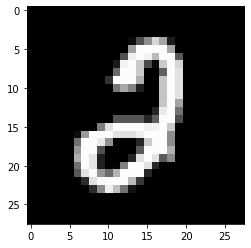

In [12]:
# 0维：image，1维：类别
print(next(iter(dataloader))[0].shape)

# cmap控制显示的颜色
plt.imshow(next(iter(dataloader))[0][1][0], cmap=plt.cm.gray)

## 网络训练

In [13]:
def reset_grad():   # 这里是梯度清零操作
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(dataloader)
num_epochs = 50
for epoch in range(num_epochs):
    # _代表的是图片的真实类别，但是这里不需要，只需要判别器判别真假即可
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)    # 32  
        images = images.reshape(batch_size, image_size).to(device)  # [32, 28, 28]
        
        real_labels = torch.ones(batch_size, 1).to(device)   # 真实的labels
        fake_labels = torch.zeros(batch_size, 1).to(device)   # 假的labels
        
        outputs = D(images)    # 判别器先用真实的图片进行训练
        d_loss_real = loss_fn(outputs, real_labels)   # 求损失
        # 0-1之间的数字，判别器能够判断出这是真实数字，对于D来说，分数越大越好
        real_score = outputs
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)  # 开始随机生成一些像素
        fake_images = G(z)    # 生成一张图片，用生成器进行判别
        outputs = D(fake_images.detach())  #  把生成器生成的图片从计算图上摘下来
        d_loss_fake = loss_fn(outputs, fake_labels)
        # 对于D来说，这个分数越小越好，因为这个是假的，生成器目标就是识别为0
        fake_score = outputs
        
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 优化generator，尽可能的让生成器生成更真实的图片，至少让当前这一代的判别器看不出来
        z = torch.randn(batch_size, latent_size).to(device)   # 随机生成图片
        fake_images = G(z)
        outputs = D(fake_images)    # 判别器进行辨认
        # 这是生成器的损失，判别器判别了之后，想办法让它看成是真的 
        g_loss = loss_fn(outputs, real_labels)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

Epoch [0/50], Step [0/1875], d_loss: 1.4248, g_loss: 0.6908, D(x): 0.48, D(G(z)): 0.50
Epoch [0/50], Step [1000/1875], d_loss: 0.1604, g_loss: 4.0191, D(x): 0.90, D(G(z)): 0.03
Epoch [1/50], Step [0/1875], d_loss: 0.4373, g_loss: 2.9504, D(x): 0.96, D(G(z)): 0.30
Epoch [1/50], Step [1000/1875], d_loss: 0.4956, g_loss: 2.7967, D(x): 0.96, D(G(z)): 0.33
Epoch [2/50], Step [0/1875], d_loss: 0.2847, g_loss: 3.4630, D(x): 0.88, D(G(z)): 0.09
Epoch [2/50], Step [1000/1875], d_loss: 0.3269, g_loss: 2.3516, D(x): 0.95, D(G(z)): 0.22
Epoch [3/50], Step [0/1875], d_loss: 0.0798, g_loss: 4.7452, D(x): 0.97, D(G(z)): 0.03
Epoch [3/50], Step [1000/1875], d_loss: 0.3691, g_loss: 4.4055, D(x): 0.85, D(G(z)): 0.03
Epoch [4/50], Step [0/1875], d_loss: 0.3175, g_loss: 4.0453, D(x): 0.88, D(G(z)): 0.02
Epoch [4/50], Step [1000/1875], d_loss: 0.4607, g_loss: 2.9470, D(x): 0.95, D(G(z)): 0.20
Epoch [5/50], Step [0/1875], d_loss: 0.1783, g_loss: 5.9930, D(x): 0.96, D(G(z)): 0.07
Epoch [5/50], Step [1000/187

Epoch [46/50], Step [0/1875], d_loss: 1.1564, g_loss: 1.5043, D(x): 0.59, D(G(z)): 0.33
Epoch [46/50], Step [1000/1875], d_loss: 0.9901, g_loss: 1.5736, D(x): 0.61, D(G(z)): 0.25
Epoch [47/50], Step [0/1875], d_loss: 1.0675, g_loss: 1.3019, D(x): 0.68, D(G(z)): 0.35
Epoch [47/50], Step [1000/1875], d_loss: 0.7706, g_loss: 1.0500, D(x): 0.75, D(G(z)): 0.31
Epoch [48/50], Step [0/1875], d_loss: 0.8211, g_loss: 1.5505, D(x): 0.68, D(G(z)): 0.23
Epoch [48/50], Step [1000/1875], d_loss: 0.9588, g_loss: 1.2922, D(x): 0.75, D(G(z)): 0.36
Epoch [49/50], Step [0/1875], d_loss: 0.8837, g_loss: 1.1230, D(x): 0.71, D(G(z)): 0.33
Epoch [49/50], Step [1000/1875], d_loss: 0.7560, g_loss: 1.7011, D(x): 0.70, D(G(z)): 0.23


## 效果

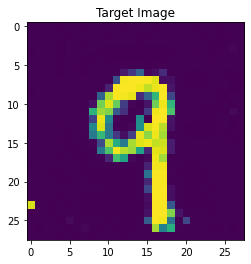

In [14]:
z = torch.randn(1, latent_size).to(device)
fake_images = G(z).view(28, 28).data
plt.figure()
imshow(fake_images, title='Target Image')

## 保存图片

In [15]:
vutils.save_image(fake_images, 'target.png', normalize=True)

# DCGAN

论文：
- 《UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS》
- https://arxiv.org/pdf/1511.06434.pdf

同样是GAN，训练过程与手写数字识别一致，仅仅是神经网络的架构变得复杂。

这里用了卷积的一些操作，生成器里用到了逆卷积的一些操作。

关键：弄清楚网络每一步操作之后数据的维度变化，尤其是生成器里，最终的输出一定要和真实图片的大小对应起来，这时候判别器才能够进行分类。

代码逻辑：
- 数据部分：数据集采用二次元数据集，大小是[3, 64, 64]

生成器结构
<img style="float: center;" src="images/14.png" width="70%">

生成器的输入[100, 1, 1]是一个张量，需要通过一系列逆卷积操作，把它变成最终的[3. 64, 64]，之后的代码就是在实现这样一个结构，不过每一层通道数改了一下，变成[512, 256, 128, 64]，其他没变。

判别器的定义，用了卷积操作，想办法从输入的[3, 64, 64]通过一些卷积变成了[1, 1, 1]，然后sigmoid一下进行二分类。

有了这些，训练的方式和上面手写数字识别差不多，这里要重点关注的是这些维度的变化，运用什么操作可以使这些维度发生变化。

## 构建DataLoader

In [93]:
image_size = 64
batch_size = 128
dataroot="data/cartoon"
num_workers = 2

# ImageFolder里实现dataset，然后进行一些预处理操作，最后转成DataLoader
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## 搭建网络

定义一个权重初始化函数，好的初始化方式不仅能保证训练快速，还可以减少一些意外情况的发生。

生成器与判别器网络中应该定义哪些层才会使得维度发生变化（很重要），每个层之后数据到底怎么变了

In [94]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:   # 卷积层的参数初始化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm的参数初始化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

nz = 100 # latent vector的大小
ngf = 64 # generator feature map size
ndf = 64 # discriminator feature map size
nc = 3 # color channels

### 生成器

In [95]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # torch.nn.ConvTranspose2d(in_channels, out_channels, 
            # kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
            # 输入是[100, 1, 1]
            # 卷积逆操作 (In-1) * stride + kernel_size - 2*padding = Out
            # 卷积操作  Out = (In+2*padding-kernel_size) / stride + 1
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),  # 0+4 = 4 [ngf*8, 4, 4]
            nn.BatchNorm2d(ngf * 8),  # [ngf*8, 4, 4]
            nn.ReLU(True),   # [ngf*8, 4, 4]
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # (4-1)*2+4-2=8 [ngf*4, 8, 8]
            nn.BatchNorm2d(ngf * 4),  # [ngf*4, 8, 8]
            nn.ReLU(True),   # [ngf*4, 8, 8]
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False), # (8-1)*2+4-2 = 16
            nn.BatchNorm2d(ngf * 2),  # [ngf*2, 16, 16]
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),  # （16-1）*2+4-2 = 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), # (3, 64, 64)
            nn.Tanh()
            # state size. (nc) x 64 x 64  这个一定要和真实图片大小对应起来
        ) 

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 判别器

In [96]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),    # [ndf, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),   # [ndf*2, 16, 16]
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # [ndf*4, 8, 8]
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # [ndf*8, 4, 4]
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),   # [1, 1, 1]
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator().to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 模型训练

In [97]:
lr = 0.0002
beta1 = 0.5

loss_fn = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)   # 生成图片过程中加了一点噪声
d_optimizer = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [98]:
num_epochs = 20
G_losses = []
D_losses = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        # 训练discriminator, maximize log(D(x)) + log(1-D(G(z)))
        
        # 首先训练真实图片
        netD.zero_grad()
        
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones(b_size).to(device)    # 真图片的标签是1
        output = netD(real_images).view(-1)    # 判别器学习真的图片
        
        
        real_loss = loss_fn(output, label)    
        real_loss.backward()
        D_x = output.mean().item()
        
        
        # 然后训练生成的假图片
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)    # 生成了假的图片
        label.fill_(0)     # 假的图片标签是0
        output = netD(fake_images.detach()).view(-1)
        fake_loss = loss_fn(output, label)    # 判别器判断假的图片
        fake_loss.backward()
        D_G_z1 = output.mean().item()
        loss_D = real_loss + fake_loss   # 这两个损失加起来才是判别器的损失， 能够正确的辨识真假
        d_optimizer.step()
        
        # 训练Generator 
        netG.zero_grad()
        label.fill_(1)        # 这里就是把假图片的标签弄成1，判别器进行判别， 从而进化生成器
        output = netD(fake_images).view(-1)
        loss_G = loss_fn(output, label)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        g_optimizer.step()
        
        if i % 50 == 0:
            print("[{}/{}] [{}/{}] Loss_D: {:.4f} Loss_G {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}"
                 .format(epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

[0/20] [0/393] Loss_D: 1.5757 Loss_G 3.9500 D(x): 0.4418 D(G(z)): 0.4070/0.0286
[0/20] [50/393] Loss_D: 0.4969 Loss_G 5.7750 D(x): 0.7971 D(G(z)): 0.0132/0.0218
[0/20] [100/393] Loss_D: 0.8457 Loss_G 4.4985 D(x): 0.6934 D(G(z)): 0.1813/0.0184
[0/20] [150/393] Loss_D: 0.7861 Loss_G 9.0480 D(x): 0.8972 D(G(z)): 0.4184/0.0004
[0/20] [200/393] Loss_D: 0.6601 Loss_G 5.1162 D(x): 0.8502 D(G(z)): 0.2581/0.0121
[0/20] [250/393] Loss_D: 0.5471 Loss_G 3.1370 D(x): 0.7596 D(G(z)): 0.1417/0.0671
[0/20] [300/393] Loss_D: 0.5949 Loss_G 3.5439 D(x): 0.8056 D(G(z)): 0.2236/0.0487
[0/20] [350/393] Loss_D: 2.5434 Loss_G 3.7151 D(x): 0.1925 D(G(z)): 0.0081/0.0510
[1/20] [0/393] Loss_D: 0.5947 Loss_G 6.3188 D(x): 0.8734 D(G(z)): 0.2772/0.0044
[1/20] [50/393] Loss_D: 0.6904 Loss_G 5.5723 D(x): 0.8628 D(G(z)): 0.3047/0.0124
[1/20] [100/393] Loss_D: 0.3026 Loss_G 5.1981 D(x): 0.8415 D(G(z)): 0.0647/0.0132
[1/20] [150/393] Loss_D: 0.6020 Loss_G 6.6616 D(x): 0.8909 D(G(z)): 0.3303/0.0046
[1/20] [200/393] Loss_

[12/20] [250/393] Loss_D: 0.7126 Loss_G 2.2724 D(x): 0.6468 D(G(z)): 0.1504/0.1705
[12/20] [300/393] Loss_D: 0.5496 Loss_G 3.2985 D(x): 0.6588 D(G(z)): 0.0461/0.0626
[12/20] [350/393] Loss_D: 0.3614 Loss_G 4.0267 D(x): 0.9371 D(G(z)): 0.2212/0.0365
[13/20] [0/393] Loss_D: 1.5858 Loss_G 8.3051 D(x): 0.9779 D(G(z)): 0.7041/0.0005
[13/20] [50/393] Loss_D: 0.5410 Loss_G 2.4027 D(x): 0.7071 D(G(z)): 0.1233/0.1261
[13/20] [100/393] Loss_D: 0.5283 Loss_G 4.1666 D(x): 0.8708 D(G(z)): 0.2794/0.0258
[13/20] [150/393] Loss_D: 1.5853 Loss_G 5.0330 D(x): 0.9866 D(G(z)): 0.7274/0.0141
[13/20] [200/393] Loss_D: 1.4188 Loss_G 5.8974 D(x): 0.9737 D(G(z)): 0.6853/0.0048
[13/20] [250/393] Loss_D: 0.4424 Loss_G 2.6885 D(x): 0.7980 D(G(z)): 0.1559/0.1026
[13/20] [300/393] Loss_D: 0.5755 Loss_G 2.4383 D(x): 0.6773 D(G(z)): 0.1107/0.1256
[13/20] [350/393] Loss_D: 0.5824 Loss_G 4.0501 D(x): 0.9260 D(G(z)): 0.3567/0.0266
[14/20] [0/393] Loss_D: 0.4980 Loss_G 3.4341 D(x): 0.8253 D(G(z)): 0.2295/0.0473
[14/20] [

In [99]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
fake_images = netG(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

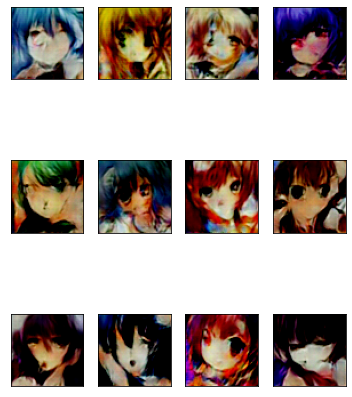

In [102]:
plt.figure(figsize=(6.,8.))
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.imshow((fake_images[i - 1].permute(1, 2, 0).detach().cpu().numpy()))
    plt.xticks([])
    plt.yticks([])
plt.show()